In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from bart_playground import *
import bartz
from stochtree import BARTModel
import time

## Concrete Compressive Strength Data

In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
concrete = fetch_ucirepo(id=165) 
  
# data (as pandas dataframes) 
X = concrete.data.features 
y = concrete.data.targets 

# variable information 
print(concrete.variables)

                            name     role        type demographic description  \
0                         Cement  Feature  Continuous        None        None   
1             Blast Furnace Slag  Feature     Integer        None        None   
2                        Fly Ash  Feature  Continuous        None        None   
3                          Water  Feature  Continuous        None        None   
4               Superplasticizer  Feature  Continuous        None        None   
5               Coarse Aggregate  Feature  Continuous        None        None   
6                 Fine Aggregate  Feature  Continuous        None        None   
7                            Age  Feature     Integer        None        None   
8  Concrete compressive strength   Target  Continuous        None        None   

    units missing_values  
0  kg/m^3             no  
1  kg/m^3             no  
2  kg/m^3             no  
3  kg/m^3             no  
4  kg/m^3             no  
5  kg/m^3             no  


In [3]:
X

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360
...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28


In [4]:
y

,Concrete compressive strength
0,79.99
1,61.89
2,40.27
3,41.05
4,44.30
...,...
1025,44.28
1026,31.18
1027,23.70
1028,32.77


In [5]:
print(X.describe())

            Cement  Blast Furnace Slag      Fly Ash        Water  \
count  1030.000000         1030.000000  1030.000000  1030.000000   
mean    281.167864           73.895825    54.188350   181.567282   
std     104.506364           86.279342    63.997004    21.354219   
min     102.000000            0.000000     0.000000   121.800000   
25%     192.375000            0.000000     0.000000   164.900000   
50%     272.900000           22.000000     0.000000   185.000000   
75%     350.000000          142.950000   118.300000   192.000000   
max     540.000000          359.400000   200.100000   247.000000   

       Superplasticizer  Coarse Aggregate  Fine Aggregate          Age  
count       1030.000000       1030.000000     1030.000000  1030.000000  
mean           6.204660        972.918932      773.580485    45.662136  
std            5.973841         77.753954       80.175980    63.169912  
min            0.000000        801.000000      594.000000     1.000000  
25%            0.00000

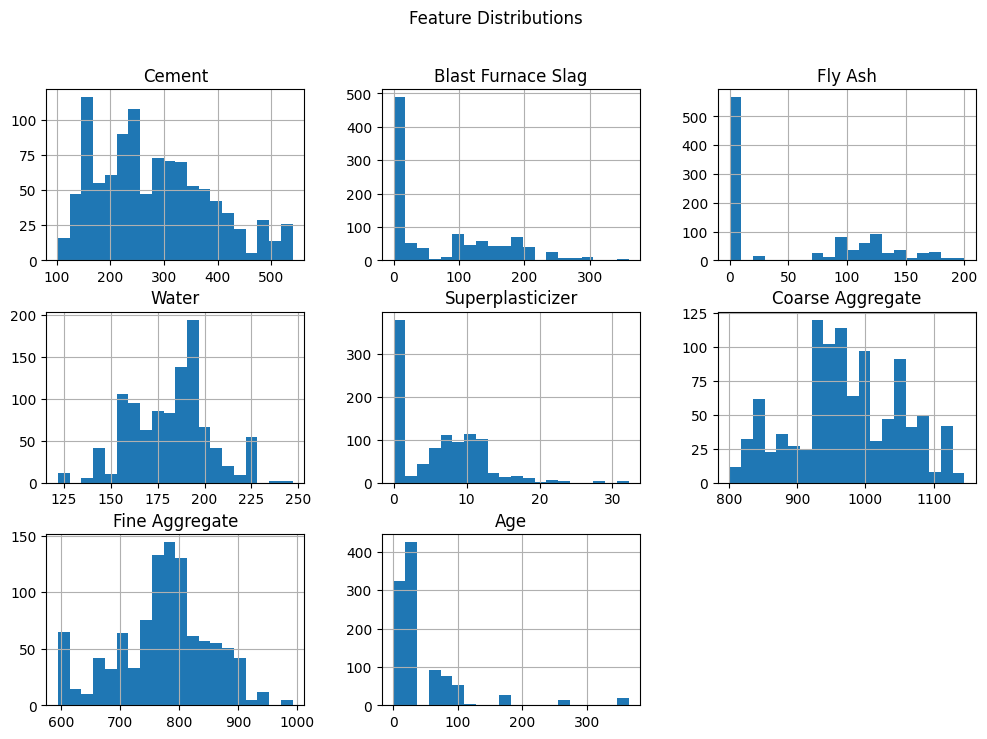

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

X.hist(figsize=(12, 8), bins=20)
plt.suptitle("Feature Distributions")
plt.show()

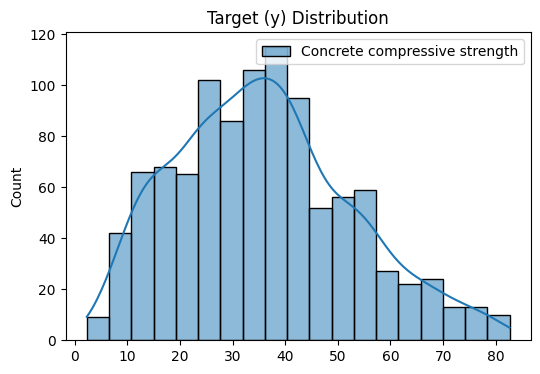

In [7]:
plt.figure(figsize=(6, 4))
sns.histplot(y, kde=True)
plt.title("Target (y) Distribution")
plt.show()

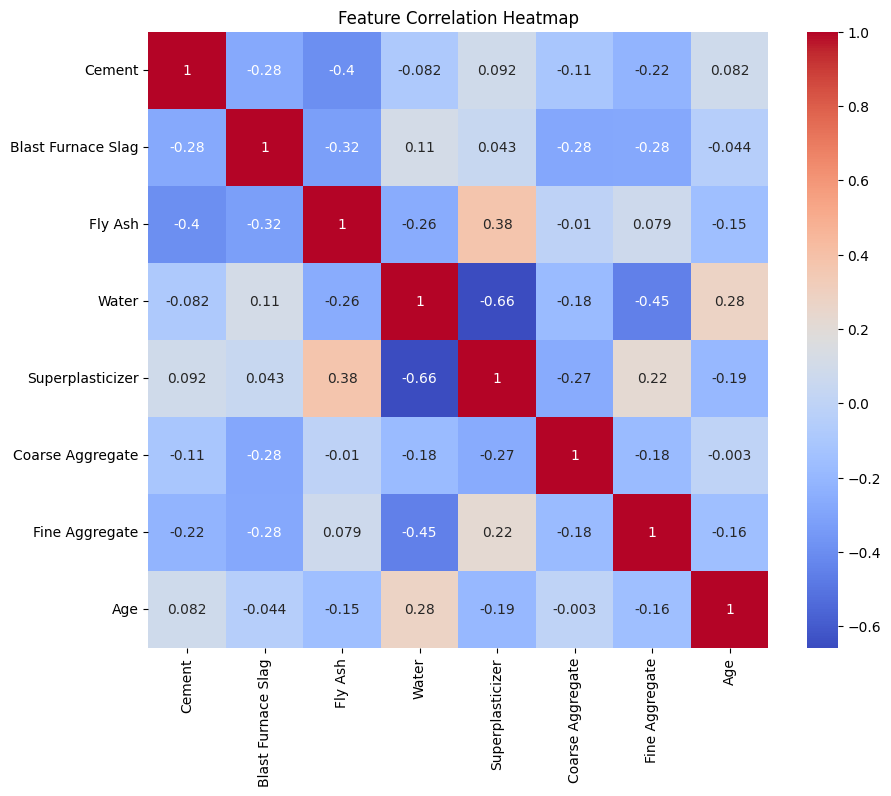

In [8]:
plt.figure(figsize=(10, 8))
corr = X.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [9]:
X = X.values.astype(float)
y = np.array(y).reshape(-1)

In [10]:
test_mse_results = {name: [] for name in ["bart", "btz", "sto", "rf", "xgb", "lr"]}
train_mse_results = {name: [] for name in ["bart", "btz", "sto", "rf", "xgb", "lr"]}
pi_length_results = {name: [] for name in ["bart", "btz", "sto"]}
coverage_results = {name: [] for name in ["bart", "btz", "sto"]}
time_results = {name: [] for name in ["bart", "btz", "sto", "rf", "xgb", "lr"]}

In [11]:
n_runs = 10
n_skip = 100
n_post = 200
n_trees = 100
for seed in range(n_runs):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)
    
    # bart
    t0 = time.time()
    bart = DefaultBART(ndpost=n_post, nskip=n_skip, n_trees=n_trees)
    bart.fit(X_train, y_train)
    time_results["bart"].append(time.time() - t0)
    
    # btz
    t0 = time.time()
    btz = bartz.BART.gbart(np.transpose(X_train), y_train, ntree=n_trees, ndpost=n_post, nskip=n_skip)
    btpred_all_test = btz.predict(np.transpose(X_test))
    btpred_test = np.mean(np.array(btpred_all_test), axis=0)
    btpred_all_train = btz.predict(np.transpose(X_train))
    btpred_train = np.mean(np.array(btpred_all_train), axis=0)
    time_results["btz"].append(time.time() - t0)
    
    # sto
    t0 = time.time()
    sto = BARTModel()
    sto.sample(X_train=X_train, y_train=y_train,
               num_gfr=0, num_burnin=n_skip, num_mcmc=n_post, 
               mean_forest_params={"num_trees": n_trees})
    sto_pred_all_test = sto.predict(X_test)
    sto_pred_test = np.mean(sto_pred_all_test, axis=1)
    sto_pred_train = np.mean(sto.predict(X_train), axis=1)
    time_results["sto"].append(time.time() - t0)

    # rf
    t0 = time.time()
    rf = RandomForestRegressor(n_estimators=n_trees, random_state=seed)
    rf.fit(X_train, y_train)
    time_results["rf"].append(time.time() - t0)

    # xgb
    t0 = time.time()
    xgbr = xgb.XGBRegressor(n_estimators=n_trees, random_state=seed, verbosity=0)
    xgbr.fit(X_train, y_train)
    time_results["xgb"].append(time.time() - t0)

    # lr
    t0 = time.time()
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    time_results["lr"].append(time.time() - t0)
    
    # Test MSE
    test_mse_results["bart"].append(mean_squared_error(y_test, bart.predict(X_test)))
    test_mse_results["btz"].append(mean_squared_error(y_test, btpred_test))
    test_mse_results["sto"].append(mean_squared_error(y_test, sto_pred_test))
    test_mse_results["rf"].append(mean_squared_error(y_test, rf.predict(X_test)))
    test_mse_results["xgb"].append(mean_squared_error(y_test, xgbr.predict(X_test)))
    test_mse_results["lr"].append(mean_squared_error(y_test, lr.predict(X_test)))

    # Train MSE
    train_mse_results["bart"].append(mean_squared_error(y_train, bart.predict(X_train)))
    train_mse_results["btz"].append(mean_squared_error(y_train, btpred_train))
    train_mse_results["sto"].append(mean_squared_error(y_train, sto_pred_train))
    train_mse_results["rf"].append(mean_squared_error(y_train, rf.predict(X_train)))
    train_mse_results["xgb"].append(mean_squared_error(y_train, xgbr.predict(X_train)))
    train_mse_results["lr"].append(mean_squared_error(y_train, lr.predict(X_train)))

    # Prediction intervals
    # btz: axis=0, shape (n_mcmc, n_test)
    btz_lower = np.percentile(btpred_all_test, 2.5, axis=0)
    btz_upper = np.percentile(btpred_all_test, 97.5, axis=0)
    pi_length_results["btz"].append(np.mean(btz_upper - btz_lower))
    btz_covered = ((y_test >= btz_lower) & (y_test <= btz_upper)).mean()
    coverage_results["btz"].append(btz_covered)
    
    # sto: axis=1, shape (n_test, n_mcmc)
    sto_lower = np.percentile(sto_pred_all_test, 2.5, axis=1)
    sto_upper = np.percentile(sto_pred_all_test, 97.5, axis=1)
    pi_length_results["sto"].append(np.mean(sto_upper - sto_lower))
    sto_covered = ((y_test >= sto_lower) & (y_test <= sto_upper)).mean()
    coverage_results["sto"].append(sto_covered)
    
    # bart: axis=1, shape (n_test, n_mcmc)
    bart_pred_all_test = bart.posterior_f(X_test)
    bart_lower = np.percentile(bart_pred_all_test, 2.5, axis=1)
    bart_upper = np.percentile(bart_pred_all_test, 97.5, axis=1)
    pi_length_results["bart"].append(np.mean(bart_upper - bart_lower))
    bart_covered = ((y_test >= bart_lower) & (y_test <= bart_upper)).mean()
    coverage_results["bart"].append(bart_covered)


Iterations: 100%|██████████| 300/300 [00:14<00:00, 21.02it/s]
INFO:2025-05-29 17:33:19,908:jax._src.xla_bridge:927: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-05-29 17:33:19,910:jax._src.xla_bridge:927: Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.


Iteration 100/300 P_grow=0.57 P_prune=0.43 A_grow=0.19 A_prune=0.14 (burnin)
Iteration 200/300 P_grow=0.57 P_prune=0.43 A_grow=0.14 A_prune=0.23
Iteration 300/300 P_grow=0.55 P_prune=0.45 A_grow=0.20 A_prune=0.16


Iterations: 100%|██████████| 300/300 [00:08<00:00, 35.54it/s]


Iteration 100/300 P_grow=0.56 P_prune=0.44 A_grow=0.14 A_prune=0.16 (burnin)
Iteration 200/300 P_grow=0.57 P_prune=0.43 A_grow=0.19 A_prune=0.30
Iteration 300/300 P_grow=0.54 P_prune=0.46 A_grow=0.22 A_prune=0.20


Iterations: 100%|██████████| 300/300 [00:07<00:00, 37.95it/s]


Iteration 100/300 P_grow=0.56 P_prune=0.44 A_grow=0.16 A_prune=0.20 (burnin)
Iteration 200/300 P_grow=0.56 P_prune=0.44 A_grow=0.16 A_prune=0.39
Iteration 300/300 P_grow=0.55 P_prune=0.45 A_grow=0.18 A_prune=0.13


Iterations: 100%|██████████| 300/300 [00:07<00:00, 38.04it/s]


Iteration 100/300 P_grow=0.55 P_prune=0.45 A_grow=0.18 A_prune=0.22 (burnin)
Iteration 200/300 P_grow=0.57 P_prune=0.43 A_grow=0.18 A_prune=0.26
Iteration 300/300 P_grow=0.56 P_prune=0.44 A_grow=0.18 A_prune=0.14


Iterations: 100%|██████████| 300/300 [00:07<00:00, 37.71it/s]


Iteration 100/300 P_grow=0.60 P_prune=0.40 A_grow=0.27 A_prune=0.28 (burnin)
Iteration 200/300 P_grow=0.57 P_prune=0.43 A_grow=0.19 A_prune=0.30
Iteration 300/300 P_grow=0.55 P_prune=0.45 A_grow=0.09 A_prune=0.22


Iterations: 100%|██████████| 300/300 [00:08<00:00, 36.12it/s]


Iteration 100/300 P_grow=0.56 P_prune=0.44 A_grow=0.25 A_prune=0.14 (burnin)
Iteration 200/300 P_grow=0.55 P_prune=0.45 A_grow=0.18 A_prune=0.13
Iteration 300/300 P_grow=0.57 P_prune=0.43 A_grow=0.21 A_prune=0.23


Iterations: 100%|██████████| 300/300 [00:07<00:00, 39.97it/s]


Iteration 100/300 P_grow=0.59 P_prune=0.41 A_grow=0.22 A_prune=0.15 (burnin)
Iteration 200/300 P_grow=0.55 P_prune=0.45 A_grow=0.16 A_prune=0.27
Iteration 300/300 P_grow=0.56 P_prune=0.44 A_grow=0.14 A_prune=0.11


Iterations: 100%|██████████| 300/300 [00:07<00:00, 39.58it/s]


Iteration 100/300 P_grow=0.61 P_prune=0.39 A_grow=0.23 A_prune=0.15 (burnin)
Iteration 200/300 P_grow=0.57 P_prune=0.43 A_grow=0.19 A_prune=0.26
Iteration 300/300 P_grow=0.57 P_prune=0.43 A_grow=0.23 A_prune=0.16


Iterations: 100%|██████████| 300/300 [00:08<00:00, 35.38it/s]


Iteration 100/300 P_grow=0.57 P_prune=0.43 A_grow=0.26 A_prune=0.16 (burnin)
Iteration 200/300 P_grow=0.56 P_prune=0.44 A_grow=0.20 A_prune=0.20
Iteration 300/300 P_grow=0.56 P_prune=0.44 A_grow=0.12 A_prune=0.16


Iterations: 100%|██████████| 300/300 [00:07<00:00, 38.13it/s]


Iteration 100/300 P_grow=0.56 P_prune=0.44 A_grow=0.20 A_prune=0.11 (burnin)
Iteration 200/300 P_grow=0.56 P_prune=0.44 A_grow=0.12 A_prune=0.18
Iteration 300/300 P_grow=0.54 P_prune=0.46 A_grow=0.13 A_prune=0.26


In [12]:
import pandas as pd

test_mse_df = pd.DataFrame(test_mse_results)
train_mse_df = pd.DataFrame(train_mse_results)
pi_length_df = pd.DataFrame(pi_length_results)
coverage_df = pd.DataFrame(coverage_results)
time_df = pd.DataFrame(time_results)

print(f"Test MSE ({n_runs} runs):")
print(f"Train MSE ({n_runs} runs):")
print("Test MSE Mean:")
print(test_mse_df.mean())
print("Train MSE Mean:")
print(train_mse_df.mean())

print(f"Prediction Interval Mean Length ({n_runs} runs):")
print(f"Prediction Interval Mean Length (Mean over {n_runs} runs):")
print(pi_length_df.mean())

print(f"Prediction Interval Coverage Mean ({n_runs} runs):")
print(coverage_df.mean())

print(f"Average Training Time (seconds) over {n_runs} runs:")
print(time_df.mean())

Test MSE (10 runs):
Train MSE (10 runs):
Test MSE Mean:
bart     20.960659
btz      21.845860
sto      21.406600
rf       25.443983
xgb      21.789741
lr      112.593759
dtype: float64
Train MSE Mean:
bart     10.891091
btz      11.611098
sto      10.848988
rf        4.335753
xgb       1.179485
lr      105.950499
dtype: float64
Prediction Interval Mean Length (10 runs):
Prediction Interval Mean Length (Mean over 10 runs):
bart    6.812394
btz     7.265329
sto     7.360860
dtype: float64
Prediction Interval Coverage Mean (10 runs):
bart    0.606202
btz     0.627519
sto     0.639922
dtype: float64
Average Training Time (seconds) over 10 runs:
bart    8.636921
btz     4.086718
sto     0.805097
rf      0.375435
xgb     0.070089
lr      0.001197
dtype: float64


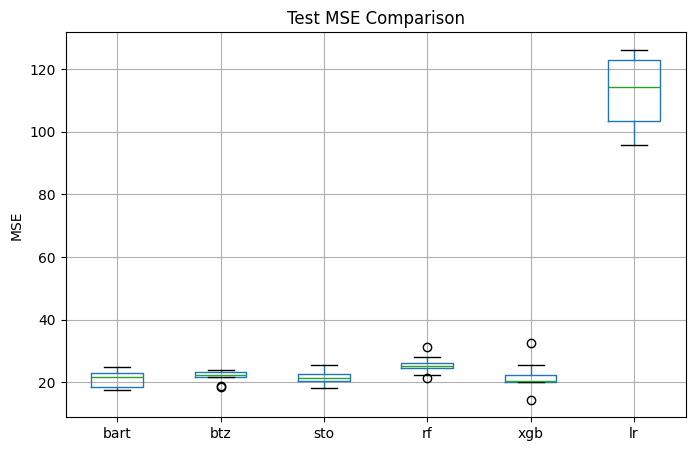

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
test_mse_df.boxplot()
plt.title("Test MSE Comparison")
plt.ylabel("MSE")
plt.grid(True, axis='y')
plt.show()

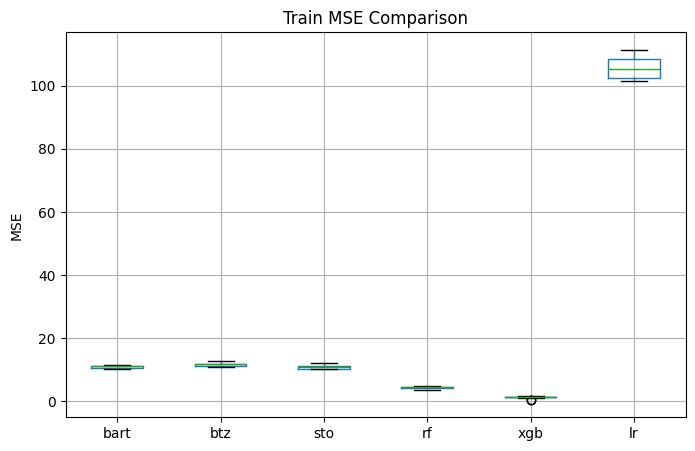

In [14]:
plt.figure(figsize=(8, 5))
train_mse_df.boxplot()
plt.title("Train MSE Comparison")
plt.ylabel("MSE")
plt.grid(True, axis='y')
plt.show()

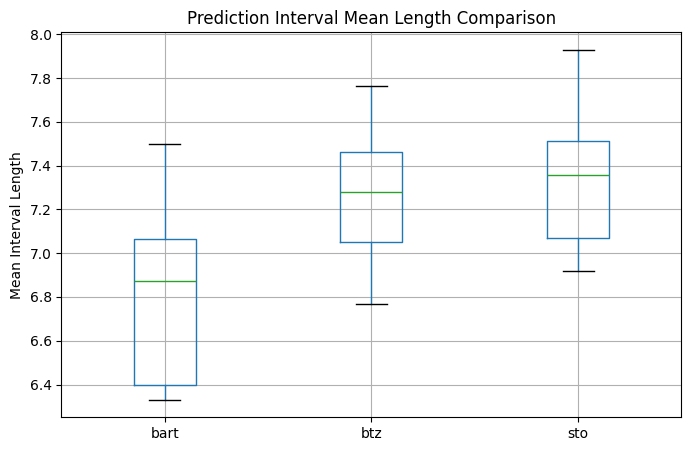

In [15]:
plt.figure(figsize=(8, 5))
pi_length_df.boxplot()
plt.title("Prediction Interval Mean Length Comparison")
plt.ylabel("Mean Interval Length")
plt.grid(True, axis='y')
plt.show()

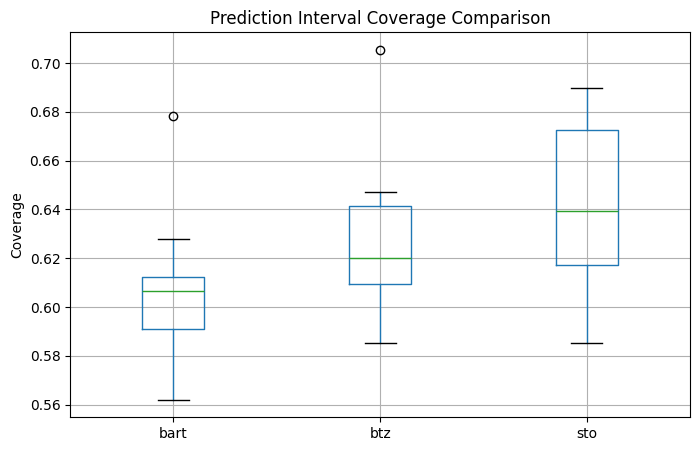

In [16]:
plt.figure(figsize=(8, 5))
coverage_df.boxplot()
plt.title("Prediction Interval Coverage Comparison")
plt.ylabel("Coverage")
plt.grid(True, axis='y')
plt.show()

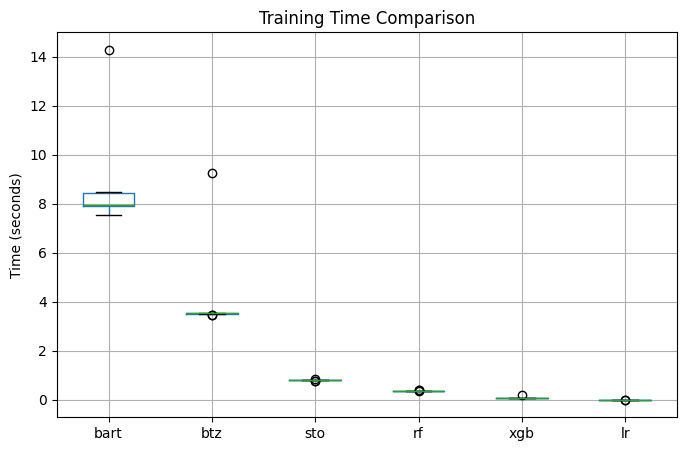

In [17]:
plt.figure(figsize=(8, 5))
time_df.boxplot()
plt.title("Training Time Comparison")
plt.ylabel("Time (seconds)")
plt.grid(True, axis='y')
plt.show()